### Introduction

The aim of this project is to determine the statistically best air purifier brand available on an e-commerce site. The motivation for this project comes from living in a neighborhood with high levels of PM2.5 pollution, which poses a health risk to family. 

To mitigate the effects of the pollution, i have decided to purchase an air purifier, but is unsure which brand to choose. To address this, the project will analyze statistical data on various brands available on the e-commerce site. By using statistical analysis to determine the best brand based on specific purchasing metrics, the project aims to provide valuable guidance to the me and potentially other individuals facing a similar challenge.

**Please note** that this project is not intended to provide purchasing advice for air purifiers to the general public. Rather, it is a personal project that documents my journey in data analysis. The findings should not be used as the sole basis for making a purchasing decision, as there are many other factors beyond the scope of this analysis that can make one brand of air purifier better suited for individual needs. It is important to consider all relevant factors, consult with experts, and exercise caution when making important decisions. While data analysis can provide valuable insights, it is not a substitute for professional advice or expertise.

In [1]:
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
pm = pd.read_csv('pm25.csv')
data = pd.read_json('airpure500.json')
data = pd.json_normalize(data.to_dict(orient='records'))

I obtained a reliable PM2.5 dataset that includes the AQI in my area. Additionally, I obtained an e-commerce air purifier dataset from Shopee, which contains listings from various brands. To gather this information, I used a web scraper from APIFY.com to extract the relevant data from the website.

### PM 2.5 Severity

First, let's assess the severity of PM2.5 pollution in my area. 

From the beginning of 2023 until now, it appears that on most days, the AQI level falls within the yellow zone, indicating an unhealthy amount of PM2.5 in the air. The average AQI level during this time period was 122.65 which is considerably high. This is concerning and suggests that it is not advisable to spend prolonged periods of time outdoors.

In [2]:
pm['date'] = pd.to_datetime(pm['date'])
pm[' pm25'] = pm[' pm25'].str.strip()
pm = pm.drop(columns=[' pm10',' o3',' no2',' so2',' co'])

(array([19358., 19365., 19372., 19379., 19389., 19396., 19403., 19410.]),
 [Text(19358.0, 0, '2023-01-01'),
  Text(19365.0, 0, '2023-01-08'),
  Text(19372.0, 0, '2023-01-15'),
  Text(19379.0, 0, '2023-01-22'),
  Text(19389.0, 0, '2023-02-01'),
  Text(19396.0, 0, '2023-02-08'),
  Text(19403.0, 0, '2023-02-15'),
  Text(19410.0, 0, '2023-02-22')])

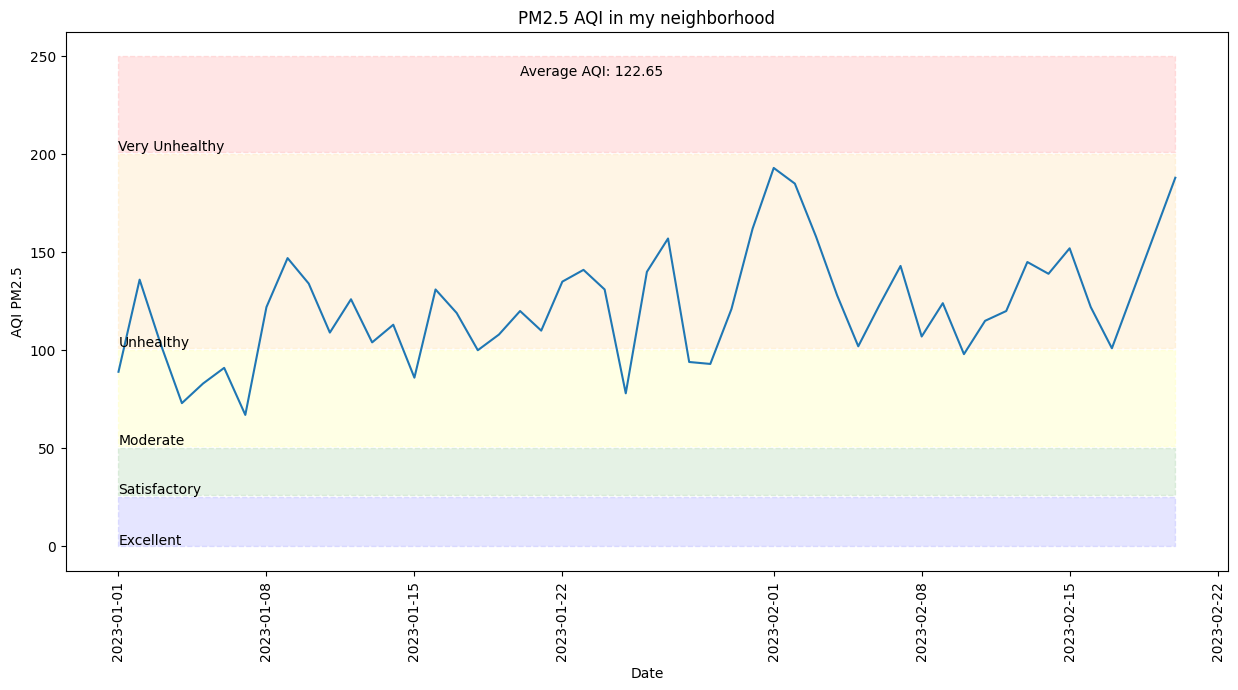

In [3]:
x = [datetime(2023,1,1) , datetime(2023,2,20)]
pm2023 = pm[pm['date'] >= '2023-01-01']
pm2023[' pm25']= pm2023[' pm25'].astype('int')
pm2023['date'] = pd.to_datetime(pm2023['date'])
pm2023 = pm2023.set_index('date')

averageaqi = pm2023[' pm25'].mean()
plt.figure(figsize=(15,7))
sns.lineplot(x='date', y=' pm25', data=pm2023)
plt.title('PM2.5 AQI in my neighborhood')
plt.xlabel('Date')
plt.ylabel('AQI PM2.5')

text_x = datetime(2023,1,1)
plt.text(text_x, 1, 'Excellent')
plt.text(text_x, 27, 'Satisfactory')
plt.text(text_x, 52, 'Moderate')
plt.text(text_x, 102, 'Unhealthy')
plt.text(text_x, 202, 'Very Unhealthy')

plt.text(datetime(2023,1,20),240, f"Average AQI: {round(averageaqi,2)}")
plt.fill_between(x=x,y1=0,y2=25, color='blue', alpha=0.1, linestyle='--')
plt.fill_between(x=x,y1=26,y2=50, color='green', alpha=0.1, linestyle='--')
plt.fill_between(x=x,y1=51,y2=100, color='yellow', alpha=0.1, linestyle='--')
plt.fill_between(x=x,y1=101,y2=200, color='orange', alpha=0.1, linestyle='--')
plt.fill_between(x=x,y1=201,y2=250, color='red', alpha=0.1, linestyle='--')
plt.xticks(rotation=90)

### Shopee E-commerce air purifer dateset 

Now lets look at out main section, which air purifier brand to choose!

Preview of a scraped raw data

In [4]:
data.head(10)

,images,item.itemid,item.brand,item.brand_id,item.name,item.product_url,item.description,categories.category,categories.Subcategory_1,categories.Subcategory_2,categories.Subcategory_N,item_rating.rating_average,item_rating.rating_count,price.price,price.price_before_discount,price.price_max,price.price_max_before_discount,price.price_min,price.price_min_before_discount,price.raw_discount,price.discount,price.discount_stock,price.product_sold,shop.shop_location,shop.shopid,shop.item_sold,shop.item_stock
0,[https://cf.shopee.com.my/file/th-11134207-230...,14550497259,None,0,Lecon เครื่องฟอกอากาศ Air Purifier พื้นที่ใหญ่...,https://shopee.co.th/lecon-air-purifier-40-100...,---------- Lecon เครื่องฟอกอากาศ Air Purifier ...,เครื่องใช้ไฟฟ้าภายในบ้าน,เครื่องฟอกอากาศ,เครื่องฟอกอากาศ,Lecon เครื่องฟอกอากาศ Air Purifier พื้นที่ใหญ่...,4.666667,"[3, 0, 0, 0, 1, 2]",799,1590,1599,2299.00000,799,1590.00000,50,50%,55,8,จังหวัดสมุทรสาคร,548498080,3,55
1,[https://cf.shopee.com.my/file/3f1028f8358f6e0...,7834462033,None,0,Kare Well แคร์เวล รุ่น Mini Air Purifier เครื่...,https://shopee.co.th/kare-well-mini-air-purifi...,“ผลิตภัณฑ์กรองอากาศด้วยการยิงประจุไอออนไปเพื่อ...,เครื่องใช้ไฟฟ้าภายในบ้าน,เครื่องฟอกอากาศ,เครื่องฟอกอากาศ,Kare Well แคร์เวล รุ่น Mini Air Purifier เครื่...,4.846154,"[130, 1, 0, 1, 14, 114]",1190,0,1190,-0.00001,1190,-0.00001,0,None,0,345,จังหวัดกรุงเทพมหานคร,15094012,2,85
2,[https://cf.shopee.com.my/file/sg-11134201-221...,18269795908,Bionic Cube(ไบโอนิค คิวบ์),2317919,Bionic Cube The Portable Filterless Air Purifier,https://shopee.co.th/bionic-cube-the-portable-...,รายละเอียดสินค้า\n- ชื่อผลิตภัณฑ์ : Bionic Cub...,เครื่องใช้ไฟฟ้าภายในบ้าน,เครื่องฟอกอากาศ,เครื่องฟอกอากาศ,Bionic Cube The Portable Filterless Air Purifier,0.000000,"[0, 0, 0, 0, 0, 0]",4979,0,4979,-0.00001,4979,-0.00001,0,None,0,0,จังหวัดกรุงเทพมหานคร,129218989,0,1
3,[https://cf.shopee.com.my/file/sg-11134201-221...,3900448855,Xiaomi(เสี่ยวมี่),1147183,[รับ500C. code KPSMLR3R] Xiaomi Mi Air Purifie...,https://shopee.co.th/500c-code-kpsmlr3r-xiaomi...,==============================================...,เครื่องใช้ไฟฟ้าภายในบ้าน,เครื่องฟอกอากาศ,เครื่องฟอกอากาศ,[รับ500C. code KPSMLR3R] Xiaomi Mi Air Purifie...,4.822095,"[4184, 19, 17, 72, 479, 3597]",3489,6500,3499,7900.00000,3489,6500.00000,56,56%,608,9570,จังหวัดกรุงเทพมหานคร,111580283,411,608
4,[https://cf.shopee.com.my/file/8217f39b9a934e6...,19800039514,Sabaidee​ Care(สบายดีแคร์),1159059,Sabaidee Care Wearable Air Purifier สบายดีแคร์...,https://shopee.co.th/sabaidee-care-wearable-ai...,SABAIDEECARE GADGETS\n- เครื่องฟอกอากาศไอออนแบ...,เครื่องใช้ไฟฟ้าภายในบ้าน,เครื่องฟอกอากาศ,เครื่องฟอกอากาศ,Sabaidee Care Wearable Air Purifier สบายดีแคร์...,5.000000,"[3, 0, 0, 0, 0, 3]",1490,1990,1490,1990.00000,1490,1990.00000,25,25%,93,6,จังหวัดกรุงเทพมหานคร,15094012,4,93
5,[https://cf.shopee.com.my/file/sg-11134201-221...,16225377874,MEDIA(มีเดีย),1381469,(ส่งฟรี) Media เครื่องฟอกอากาศ กรองฝุ่น ควัน A...,https://shopee.co.th/media-air-purifier-kj360f...,*** สินค้าใหม่ มือ 1 ***\n*** ส่งฟรีทุกออเดอร์...,เครื่องใช้ไฟฟ้าภายในบ้าน,เครื่องฟอกอากาศ,เครื่องฟอกอากาศ,(ส่งฟรี) Media เครื่องฟอกอากาศ กรองฝุ่น ควัน A...,5.000000,"[16, 0, 0, 0, 0, 16]",3990,9990,3990,9990.00000,3990,9990.00000,60,60%,65,19,จังหวัดกรุงเทพมหานคร,263425249,1,65
6,[https://cf.shopee.com.my/file/74225d087ea9af1...,5618551172,Imarflex(อิมาร์เฟล็กซ์),1117974,[สินค้าใหม่] IMARFLEX เครื่องฟอกอากาศ สีทูโทน ...,https://shopee.co.th/imarflex-f-c042r-pm-2-5--...,รายละเอียดสินค้า \n\nได้รับมาตรฐานอุตสาหกรรม ม...,เครื่องใช้ไฟฟ้าภายในบ้าน,เครื่องฟอกอากาศ,เครื่องฟอกอากาศ,[สินค้าใหม่] IMARFLEX เครื่องฟอกอากาศ สีทูโทน ...,4.738462,"[326, 1, 1, 14, 50, 260]",1790,2590,1790,2590.00000,1790,2590.00000,31,31%,286,595,จังหวัดกรุงเทพมหานคร,94452789,3,286
7,[https://cf.shopee.com.my/file/f16919ddb362635...,12606032317,TCL(ทีซีแอล),1802651,TCL เครื่องฟอกอากาศ Air Purifier 32 SQM | ไส้ก...,https://shopee.co.th/tcl-air-purifier-32-sqm-h...,\nCADR (อัตราการสร้างอากาศที่บริสุทธิ์): 270 ล...

After analyzing the raw dataset, I identified several issues that made it difficult to analyze. To address these issues, I performed the following data cleaning steps:

- Removed any irrelevant columns that are not useful for our analysis.
- Separated the 1-5 star reviews, which were in the form of a list, into separate columns to determine which products had the most 5-star reviews.
- Removed any listings that were not relevant to air purifiers, as they were not useful for our analysis.
- There were some entries that did not have the brand indicator, but the brand name was mentioned in the description. To address this, I created a function to search for any brand names in the description and assign the brand to the corresponding column.
- Renamed columns to make them coherent and easy to understand.

These data cleaning steps were time-consuming, but necessary to ensure that our analysis is accurate and meaningful.

In [5]:
#separate the list of rating into different columns
data['item_rating.rating_count'] = data['item_rating.rating_count'].apply(lambda x:','.join(map(str,x)))
data[['rating_count', 'one_star', 'two_star','three_star','four_star','five_star']] = data['item_rating.rating_count'].str.split(',', expand=True)

In [6]:
#subset only the air purifier products
data = data[(data['categories.Subcategory_2'] == 'เครื่องฟอกอากาศ') & (data['categories.Subcategory_1'] == 'เครื่องฟอกอากาศ')]
data = data.drop(columns=['item_rating.rating_count','images','shop.shopid','categories.category','item.product_url','item.description','categories.Subcategory_1','categories.Subcategory_1','item.brand_id'])

#remove irrelevent price columns left only price, discount%, stock level
price_drop = ['price.price_before_discount','price.price_max','price.price_max_before_discount','price.price_min','price.price_min_before_discount','price.discount','price.discount_stock','shop.item_sold']
data = data.drop(columns=price_drop)


In [7]:
english_pattern = '[a-zA-Z]+'

def eng_extract(text):
    return re.findall(english_pattern,text)

has_brand_filter = data['item.brand'].notna()
none_brand_filter = data['item.brand'].isna()

#extract english brand name
data['item.brand'] = data[has_brand_filter]['item.brand'].apply(eng_extract)
data['item.brand'] = data[has_brand_filter]['item.brand'].apply(lambda x:' '.join(map(str,x)))
data['item.brand'] = data['item.brand'].str.upper()

In [8]:
#if item.brand = None, lets' find out hidden brand name in subcateories description
data['categories.Subcategory_N'] = data['categories.Subcategory_N'].apply(eng_extract)
data['categories.Subcategory_N'] = data['categories.Subcategory_N'].apply(lambda x:','.join(map(str,x)))
data['categories.Subcategory_N'] = data['categories.Subcategory_N'].str.upper().str.replace(',',' ')

brandlist = data[has_brand_filter]['item.brand'].str.upper().drop_duplicates().tolist()
brandlist = [item for item in brandlist if item != 'T']

data['brand_match'] = data['categories.Subcategory_N'].str.extract('(' + '|'.join(brandlist) + ')')

#if there are no brand names, fillna as Others
data['item.brand'] = data['item.brand'].fillna('OTHER')
data['brand_match'] = data['brand_match'].fillna('OTHER')
data['item.brand'] = data['brand_match']


In [9]:
#change the region name to english
data['shop.shop_location'].drop_duplicates().tolist()
new_region_name = ['Samut Sakhon',
 'Bangkok',
 'Samut Prakan',
 'Chon Buri',
 'Nonthaburi',
 'Uttaradit',
 'Phatthalung',
 'Nakhon Pathom',
 'Yala',
 'Pathum Thani',
 'Chachoengsao',
 'Nakhon Sawan',
 'Chiang Mai',
 'Prachin Buri',
 'Kanchanaburi',
 'Chiang Rai',
 'Prachuap Khiri Khan',
 'International',
 'Phitsanulok',
 'Surat Thani',
 'Samut Songkhram',
 'Ubon Ratchathani',
 'Nakhon Phanom',
 'Nakhon Nayok',
 'Phra Nakhon Si Ayutthaya',
 'Nakhon Ratchasima',
 'Ang Thong',
 'Udon Thani',
 'Korea',
 'Hong Kong',
 'Chumphon',
 'Nakhon Si Thammarat',
 'Buri Ram',
 'Songkhla',
 'Uthai Thani']

region_eng_thai = dict(zip(data['shop.shop_location'].drop_duplicates().tolist(),new_region_name))
data['shop.shop_location'] = data['shop.shop_location'].replace(region_eng_thai)

In [10]:
#rename columns
column_list = data.columns
column_list = column_list.tolist()
new_column_list = ['itemid',
 'brand',
 'item_name',
 'item_category',
 'item_Subcategory',
 'item_rating_average',
 'item_price',
 'item_discount',
 'item_sold',
 'item_shop_location',
 'item_instock',
 'item_rating_count',
 'item_onestar_rating',
 'item_twostar_rating',
 'item_threestar_rating',
 'item_fourstar_rating',
 'item_fivestar_rating']

column_name_zip = dict(zip(column_list,new_column_list))
column_name_zip

data.rename(columns=column_name_zip, inplace=True)
data = data.drop(columns='brand_match')

In [11]:
#convert the region language (so i could hopefully match with the region_code in the query)
region = pd.read_csv('region_code.csv')
region = region.sort_values(by='region_name')
#all_regionlist_eng = region['region_name'].tolist()

In [12]:
#left join the region code to the data 
data = data.merge(region, left_on='item_shop_location', right_on='region_name', how='left')
data = data.drop(columns='region_name')

In [13]:
data['item_category'] = data['item_category'].replace('เครื่องฟอกอากาศ','Air purifier')

The cleaned version of out air purifier data set are shown below

In [14]:
data.head(10)

,itemid,brand,item_name,item_category,item_Subcategory,item_rating_average,item_price,item_discount,item_sold,item_shop_location,item_instock,item_rating_count,item_onestar_rating,item_twostar_rating,item_threestar_rating,item_fourstar_rating,item_fivestar_rating,region_code
0,14550497259,OTHER,Lecon เครื่องฟอกอากาศ Air Purifier พื้นที่ใหญ่...,Air purifier,LECON AIR PURIFIER PM HMK A,4.666667,799,50,8,Samut Sakhon,55,3,0,0,0,1,2,TH-74
1,7834462033,OTHER,Kare Well แคร์เวล รุ่น Mini Air Purifier เครื่...,Air purifier,KARE WELL MINI AIR PURIFIER,4.846154,1190,0,345,Bangkok,85,130,1,0,1,14,114,TH-10
2,18269795908,BIONIC CUBE,Bionic Cube The Portable Filterless Air Purifier,Air purifier,BIONIC CUBE THE PORTABLE FILTERLESS AIR PURIFIER,0.000000,4979,0,0,Bangkok,1,0,0,0,0,0,0,TH-10
3,3900448855,XIAOMI,[รับ500C. code KPSMLR3R] Xiaomi Mi Air Purifie...,Air purifier,C CODE KPSMLR R XIAOMI MI AIR PURIFIER LITE PR...,4.822095,3489,56,9570,Bangkok,608,4184,19,17,72,479,3597,TH-10
4,19800039514,SABAIDEE CARE,Sabaidee Care Wearable Air Purifier สบายดีแคร์...,Air purifier,SABAIDEE CARE WEARABLE AIR PURIFIER,5.000000,1490,25,6,Bangkok,93,3,0,0,0,0,3,TH-10
5,16225377874,MEDIA,(ส่งฟรี) Media เครื่องฟอกอากาศ กรองฝุ่น ควัน A...,Air purifier,MEDIA AIR PURIFIER KJ F,5.000000,3990,60,19,Bangkok,65,16,0,0,0,0,16,TH-10
6,5618551172,IMARFLEX,[สินค้าใหม่] IMARFLEX เครื่องฟอกอากาศ สีทูโทน ...,Air purifier,IMARFLEX F C R PM,4.738462,1790,31,595,Bangkok,286,326,1,1,14,50,260,TH-10
7,12606032317,TCL,TCL เครื่องฟอกอากาศ Air Purifier 32 SQM | ไส้ก...,Air purifier,TCL AIR PURIFIER SQM HEPA PM BREEVA A,4.714286,3890,20,28,Samut Prakan,625,7,0,0,0,2,5,TH-11
8,11820574741,SAMSUNG,[จัดส่งฟรี] SAMSUNG เครื่องฟอกอากาศ BLUE SKY A...,Air purifier,SAMSUNG BLUE SKY AX K AX R WD ST,5.000000,10990,47,9,Chon Buri,2,2,0,0,0,0,2,TH-20
9,6819854197,XIAOMI,[ทักแชทรับโค้ด] Xiaomi Mi Air Purifier 4 Pro (...,Air purifier,XIAOMI MI AIR PURIFIER PRO PM GLOBAL VERSION,4.840000,7490,25,173,Samut Sakhon,400,75,1,0,1,6,67,TH-74


After cleaning the dataset, I discovered an issue with some of the entries. There were some listings that had very few sales, which could potentially skew the ratings and impact the accuracy of our analysis. For instance, a listing with only 1 product sold and a 5-star review would likely result in an overly optimistic rating.

To address this issue, I decided to filter out listings that had an insufficient number of sales and reviews. To do this, I utilized my knowledge of SQL queries and imported the cleaned data into Google Big Query. Then, I performed SQL queries to filter out the bad entries and retain only the listings with substantial sales and reviews.

To determine the best brands, I aggregated all the data into brand groups, including the relevant metrics such as:

- Number of listings
- Total quantity sold
- Overall average rating
- Amount of reviews
- Proportion of 5-star ratings in the reviews
- Average air purifier price of each brand

By aggregating the data in this way, we can gain a comprehensive understanding of each brand's performance, and make informed decisions based on the metrics that matter the most to us.

The SQL queries are displayed below:

In [15]:
pip install google-cloud-bigquery db-dtypes

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.3/120.3 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.0/223.0 kB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 113.0 MB/s eta 0:00:0000:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.22.0 which is incompat

In [16]:
from google.cloud import bigquery

client = bigquery.Client.from_service_account_json('trend-search-project-07de819502b9.json')

brand_zscore = """

--Criteria 1: Total listings for each brands mush higher than its mean
WITH brand_listings AS (
    SELECT
        brand,
        COUNT(*) AS listing_counts,
    FROM trend-search-project.datasets.airpure_500
    WHERE brand <> 'OTHER'
    GROUP BY brand
),

median_listing AS (
SELECT APPROX_QUANTILES(listing_counts,1)[OFFSET(CAST(0.5 AS INT64))] AS median
FROM brand_listings
),

--Criteria 2: total sold for each brand higher than average total sold of all dataset
mean_total_sold AS (
SELECT
    AVG(item_sold) AS average_quantity
FROM trend-search-project.datasets.airpure_500
WHERE brand <> 'OTHER'
)


SELECT
    brand,
    COUNT(*) AS num_listings,
    SUM(item_sold) AS total_sold,
    AVG(item_rating_average) AS overall_brand_rating,
    SUM(item_rating_count) AS total_rating_counts,
    ROUND(SUM(item_fivestar_rating) /  SUM(item_rating_count),2) * 100 AS rating_fivestar_percentage,
    ROUND(AVG(item_price),2) AS average_price
FROM trend-search-project.datasets.airpure_500
WHERE brand <> 'OTHER'
    AND item_rating_count >= 1
GROUP BY brand
HAVING 
    num_listings >= (SELECT median FROM median_listing) 
    OR total_sold >= (SELECT average_quantity FROM mean_total_sold)
ORDER BY rating_fivestar_percentage DESC, num_listings DESC;
"""
brand_table = client.query(brand_zscore).to_dataframe() 
brand_zscore_table = brand_table
brand_zscore_table

,brand,num_listings,total_sold,overall_brand_rating,total_rating_counts,rating_fivestar_percentage,average_price
0,SMARTMI,4,1309,4.921174,598,94.0,3955.00
1,SMART AIR,6,887,4.951007,387,93.0,7573.33
2,DYSON,4,8952,4.821145,214,93.0,10224.25
3,LEVOIT,15,4168,4.930180,1798,92.0,3551.53
4,DAIKIN,24,1221,4.822017,530,91.0,8042.54
5,PHILIPS,13,22798,4.895451,10563,91.0,8959.23
6,SPACE AIR,5,1697,4.922972,502,91.0,2205.20
7,SHARP,48,17308,4.919507,9010,89.0,8369.25
8,HATARI,4,939,4.925363,480,89.0,2476.75
9,XIAOMI,119,233047,4.864130,91608,88.0,3834.90


After aggregating the data by brand, we can determine the best brand to purchase. To do this, we first need to convert the data into a comparable score, called the z-score. This will allow us to compare the data across the different metrics.

Before calculating the z-score, we need to rank the factors based on their importance in our purchasing decision. To do this, we will assign a weight to each factor, representing its relative importance.

I have classified each factor as follows:

- Amount of listings: represents the availability of the product in the e-commerce market. If there are many sellers offering this brand, it must be commonly used.
- Total sold: represents the popularity of the product.
- Brand rating: represents the reliability of the brand.
- Proportion of 5-star ratings in the review: represents customer satisfaction.
- Price: represents the affordability of the product.

Note that, the weight assigned are subjective to the individual, but in this case i have assign weight equally across all mretics.

Then, we will multiply each weight by the z-score, summing them up to get the total score for each brand.
This approach will allow us to weigh each factor's importance and compare the brands' overall performance, enabling us to make informed purchasing decisions based on our specific needs and preferences.



In [17]:
brand_zscore_table = brand_zscore_table.set_index('brand')
columnlists = brand_zscore_table.columns.tolist()

#assigning weight (depends subjective opinion of customer)

numlist_weight = 0.16 #avalibility of retailers
totalsold_weight = 0.16 #popularity
brand_overall_rating = 0.16 #brand_reliability
ratingcount_weight = 0.16 #customer_engagements
star5_weight = 0.16 #product_satisfactions and others services
price_weight = 0.16 #afforability

weight = [numlist_weight, totalsold_weight,brand_overall_rating, ratingcount_weight, star5_weight, price_weight]


for wei, i in enumerate(columnlists):
    mean = brand_zscore_table[i].mean()
    std = brand_zscore_table[i].std()
    brand_zscore_table[i] = ((brand_zscore_table[i] - mean) / std) * weight[wei]
    
#If less is better
brand_zscore_table['average_price'] = brand_zscore_table['average_price'] * -1  


brand_zscore_table['overall_score'] = brand_zscore_table.sum(axis=1).round(2)
brand_zscore_table = brand_zscore_table.sort_values('overall_score', ascending=False)
brand_zscore_table = brand_zscore_table.reset_index()
brand_zscore_table

,brand,num_listings,total_sold,overall_brand_rating,total_rating_counts,rating_fivestar_percentage,average_price,overall_score
0,XIAOMI,0.622699,0.673737,0.043465,0.670729,0.022939,0.003316,2.04
1,LEVOIT,0.007395,-0.040332,0.088491,-0.039817,0.164101,0.017122,0.20
2,SMARTMI,-0.057685,-0.049251,0.082352,-0.049311,0.234682,-0.002536,0.16
3,SPACE AIR,-0.051768,-0.048041,0.083577,-0.050071,0.128811,0.082716,0.15
4,SHARP,0.202636,0.000663,0.081215,0.017242,0.058229,-0.217602,0.14
5,HATARI,-0.057685,-0.050406,0.085207,-0.050245,0.058229,0.069486,0.05
6,ERACLEAN,-0.069517,-0.042934,0.025140,-0.04526,-0.012352,0.142214,-0.00
7,PHILIPS,-0.004437,0.017791,0.064816,0.029529,0.128811,-0.246346,-0.01
8,SMART AIR,-0.045852,-0.050568,0.102688,-0.05098,0.199392,-0.178824,-0.02
9,DEERMA,-0.063601,-0.018215,-0.044362,-0.019848,-0.047642,0.157236,-0.04


In [18]:
brand_zscore_table[['brand','overall_score']].head(5)

,brand,overall_score
0,XIAOMI,2.04
1,LEVOIT,0.20
2,SMARTMI,0.16
3,SPACE AIR,0.15
4,SHARP,0.14


To clarify, based on the specific metrics and weighting used in this analysis, the data suggests that Xiaomi is the best brand to purchase an air purifier from. 

### Limitations

While the statistical analysis provided insights on the best brand based on the selected metrics and weighting system, it is important to remember that other factors may also influence a purchasing decision. For example, personal preferences, additional features, customer service, warranty, and price point may also play a significant role.

Moreover, it's worth noting that this analysis may not represent the entire market or consumer population, and may be subject to bias or other limitations. As such, it's advisable to use this analysis as one of many factors to consider when making a purchasing decision. Doing additional research, seeking expert opinions, and considering one's unique needs and preferences are crucial for making an informed decision.

It's important to note that the dataset scraped from the Shopee website may not have covered all the listings that fall under the air purifier category. Furthermore, it's possible that the algorithm may have favored Xiaomi brand over others, pushing it up the list while leaving other brands at lower listings. Therefore, while Xiaomi may have scored the highest based on our metric premises, it's important to consider other factors and do further research before making any purchasing decisions.